# 1. Data Preprocessing

## 1.1 Data Exploration

In [ ]:
# unzip the data file
# from zipfile import ZipFile


# with ZipFile('amlh_nlp_dataset_2023.zip', 'r') as zip:
#     zip.extractall()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# load the dataset
df = pd.read_csv('amlh_nlp_dataset_2023/amlh_coursework_2023_annotated.csv')
df.head()


file  start   end               text       class
0  3241_General Medicine.txt   1820  1828           cyanosis  Phenotypes
1  3241_General Medicine.txt   1327  1344  umbilical hernias  Phenotypes
2  3241_General Medicine.txt   1356  1363            ascites  Phenotypes
3  3241_General Medicine.txt   1842  1847              edema  Phenotypes
4  3241_General Medicine.txt   1526  1534           prostate  Body_parts

In [ ]:
# check shape of the dataset
df.shape


(16693, 5)

In [ ]:
# observe the number for each class
df['class'].value_counts()


class
Phenotypes    9721
Body_parts    6972
Name: count, dtype: int64

In [ ]:
def read_txt(document_name):
    '''
    Read the text from documents.

    input:
        document_name: str; name of the txt file

    output:
        text: str; content of the txt in one string
    '''
    with open(f'amlh_nlp_dataset_2023/docs/{document_name}') as target_file:
        text = target_file.read()

    return text


def words_and_sentences_count(document_name):
    '''
    Counts the approximate number of words and sentences from the text.

    input:
        document_name: str; name of the txt file

    output:
        num_words: int; approximate number of words
        num_sentence: int; approximate number of sentences
    '''
    text = read_txt(document_name)
    num_words = len(text.split())
    num_sentences = len(text.split("."))

    return num_words, num_sentences


In [ ]:
# observe one sample of the clinical notes
print(read_txt('3241_General Medicine.txt'))


PHYSICAL EXAMINATION

GENERAL APPEARANCE: 

 Well developed, well nourished, in no acute distress.

VITAL SIGNS:

  ***

SKIN:  

Inspection of the skin reveals no rashes, ulcerations or petechiae.

HEENT:

  The sclerae were anicteric and conjunctivae were pink and moist.  Extraocular movements were intact and pupils were equal, round, and reactive to light with normal accommodation.  External inspection of the ears and nose showed no scars, lesions, or masses.  Lips, teeth, and gums showed normal mucosa.  The oral mucosa, hard and soft palate, tongue and posterior pharynx were normal.

NECK:  

Supple and symmetric.  There was no thyroid enlargement, and no tenderness, or masses were felt.

CHEST: 

 Normal AP diameter and normal contour without any kyphoscoliosis.

LUNGS: 

 Auscultation of the lungs revealed normal breath sounds without any other adventitious sounds or rubs.

CARDIOVASCULAR:  

There was a regular rate and rhythm without any murmurs, gallops, rubs.  The carotid pul

In [ ]:
# create two columns to store the approx. # words and # sentences for each document
df[['num_words', 'num_sentences']] =  df.apply(
    lambda x: words_and_sentences_count(x['file']), axis=1, result_type='expand')

# calculate the approx. avg. # words per sentence
df['avg_words_per_sentence'] = round(df['num_words'] / df['num_sentences'], 2)
df.head()


file  start   end               text       class  \
0  3241_General Medicine.txt   1820  1828           cyanosis  Phenotypes   
1  3241_General Medicine.txt   1327  1344  umbilical hernias  Phenotypes   
2  3241_General Medicine.txt   1356  1363            ascites  Phenotypes   
3  3241_General Medicine.txt   1842  1847              edema  Phenotypes   
4  3241_General Medicine.txt   1526  1534           prostate  Body_parts   

   num_words  num_sentences  avg_words_per_sentence  
0        291             36                    8.08  
1        291             36                    8.08  
2        291             36                    8.08  
3        291             36                    8.08  
4        291             36                    8.08

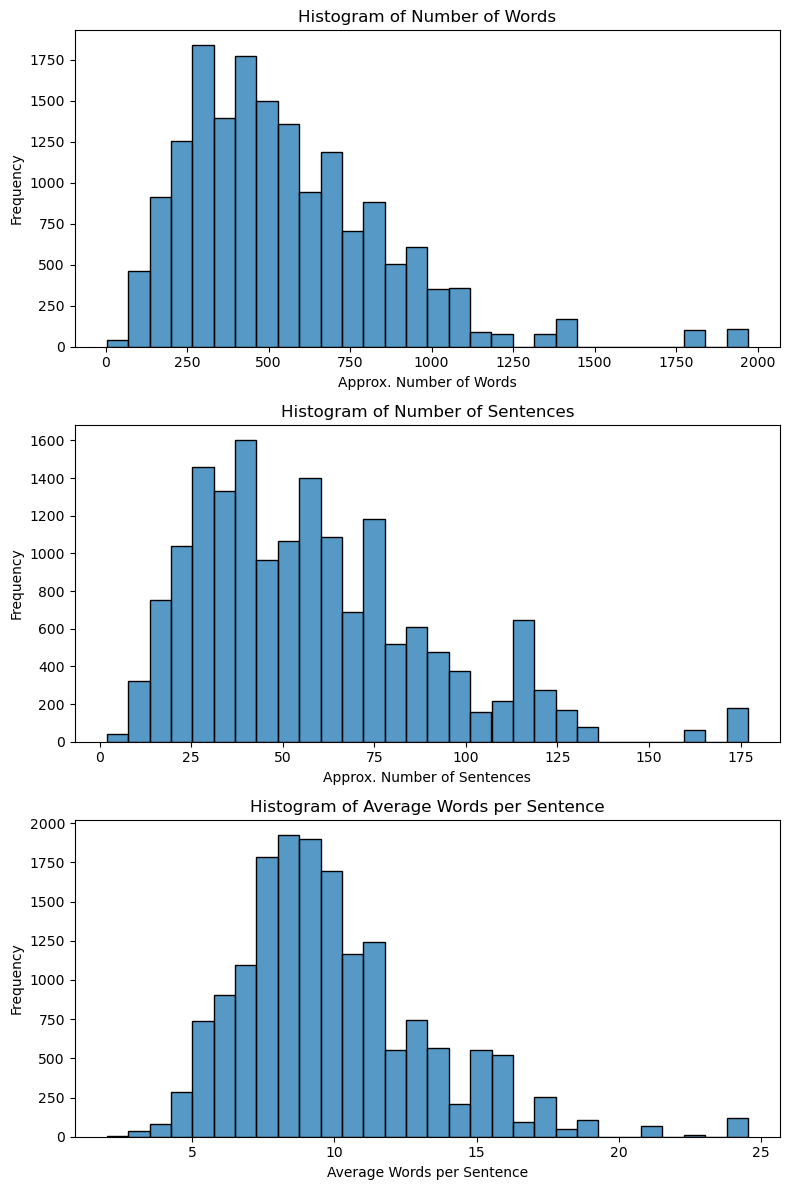

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Histogram for num_words
sns.histplot(df['num_words'], kde=False, bins=30, ax=axs[0])
axs[0].set_title('Histogram of Number of Words')
axs[0].set_xlabel('Approx. Number of Words')
axs[0].set_ylabel('Frequency')

# Histogram for num_sentences
sns.histplot(df['num_sentences'], kde=False, bins=30, ax=axs[1])
axs[1].set_title('Histogram of Number of Sentences')
axs[1].set_xlabel('Approx. Number of Sentences')
axs[1].set_ylabel('Frequency')

# Histogram for avg_words_per_sentence
sns.histplot(df['avg_words_per_sentence'], kde=False, bins=30, ax=axs[2])
axs[2].set_title('Histogram of Average Words per Sentence')
axs[2].set_xlabel('Average Words per Sentence')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
# check quantiles of the avg words per sentense
quantiles = df['num_words'].quantile([.25, .5, .75, .95])
print(quantiles)


0.25     321.0
0.50     491.0
0.75     713.0
0.95    1072.0
Name: num_words, dtype: float64


In [ ]:
# check quantiles of the avg words per sentense
quantiles = df['num_sentences'].quantile([.25, .5, .75, .95])
print(quantiles)


0.25     35.0
0.50     53.0
0.75     74.0
0.95    118.0
Name: num_sentences, dtype: float64


In [ ]:
# check quantiles of the avg words per sentense
quantiles = df['avg_words_per_sentence'].quantile([.25, .5, .75, .95])
print(quantiles)


0.25     7.87
0.50     9.33
0.75    11.48
0.95    15.78
Name: avg_words_per_sentence, dtype: float64


## 1.2 GPT-4 Prompting

Data preprocessing plan:

(1) The csv file contains the classification of the baseline nlp tool, which is high in recall for predicting phenotype. Therefore, this project assumes that words not classified as phenotypes by the baseline tool are considered "true" non-phenotypes.

(2) Words predicted as phenotypes by the NLP tool are re-evaluated using the most advanced model, GPT-4, developed by OpenAI. Due to budget limitations, only 2000 samples will be re-evaluated. If a sample is classified as a phenotype by both GPT-4 and the baseline NLP tool, it will be considered a "true" phenotype. If a sample is classified as a non-phenotype by GPT-4, it will be moved to that category.

The training and testing datasets are derived from the following sources:
~2000 samples classified as "true" phenotypes by GPT-4 & the baseline NLP tool.
~2000 baseline nlp tool classified "true" non-phenotypes + GPT-4 classified non-phenotypes

In [ ]:
# shuffle the dataframe to prepare for training and test set
# fix the random state=42 for reproducibility
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


It can be observed that the majority (75%) of the clinical notes are composed of short sentences. Each clinical note is about 713 words or 74 sentences long, and each sentence has about 11.5 words.

Therefore, in the following experiment, the context window is set to 10 words before and 10 words after the word(s) of interest, in order to cover at least one sentences and save number of tokens for gpt-4 classification.

In [ ]:
def extract_context(document_name, start, end, context_window=10):
    '''
    Extract the contents that are before and after the word(s) of interest
        from documents and remove the newline characters \n.

    input:
        document_name: str; name of the txt documents
        start: int; start position of the word(s) of interest
        end: int; end position of the word(s) of interest
        context_window: int; number of words before or after
            the word(s) of interest.

    output:
        words_before: str; chunk of texts before the word(s) of interest
            in one string
        words_after: str; chunk of texts after the word(s) of interest
            in one string
    '''
    def process_text(chunk_text):

        # replace \n with space
        out = chunk_text.replace('\n', ' ')

        # remove excessive spaces and turn into list
        out = list(filter(None, out.split(' ')))

        return out


    # read the txt document
    with open(f'amlh_nlp_dataset_2023/docs/{document_name}') as target_file:
        text = target_file.read()

    # extract words within the context window
    words_before = process_text(text[:start])[-context_window:]
    words_after = process_text(text[end+1:])[:context_window]

    return words_before, words_after


In [ ]:
# store the result into dataframe
df[['words_before', 'words_after']] = df.apply(
    lambda x: extract_context(x['file'], x['start'], x['end']), axis=1,
    result_type='expand')
df.head()


file  start   end             text       class  \
0  3949_Discharge Summary.txt   1608  1622   brain neoplasm  Phenotypes   
1  3941_Discharge Summary.txt   1505  1517     left humerus  Body_parts   
2          2842_Neurology.txt   1819  1831     polymyositis  Phenotypes   
3  3929_Discharge Summary.txt    589   604  head discomfort  Phenotypes   
4   3257_General Medicine.txt    345   349             nose  Body_parts   

   num_words  num_sentences  avg_words_per_sentence  \
0        695            118                    5.89   
1        779             54                   14.43   
2        732             73                   10.03   
3        755             91                    8.30   
4        318             35                    9.09   

                                        words_before  \
0  [in, the, pons,, which, could, be, subacute, l...   
1  [emergently, to, the, operating, room, for, su...   
2  [qweek,, Vit, E, qd,, MVI, 1, tab, qd., PMH:, 1)]   
3  [hypertension., In, addition,, the, patient, c...   
4  [appeared, normal., EARS, NOSE, AND, THROAT:, ...   

                                         words_after  
0  [could, not, be, excluded., Other, workup, inc...  
1  [fracture., In, the, operating, room,, the, pa...  
2  [diagnosed, in, 1988, by, muscle, biopsy., 2)h...  
3  [for, which, she, underwent, a, lumbar, punctu...  
4  [appeared, normal, in, appearance., Hearing, w...

In [ ]:
# keep the necessary columns and map the class as 1 and 0
df_simplified = df[['words_before', 'words_after', 'text', 'class']]
df_simplified.loc[:,'class'] = df_simplified['class'].map({'Phenotypes': 1, 'Body_parts': 0})
df_simplified.head()


words_before  \
0  [in, the, pons,, which, could, be, subacute, l...   
1  [emergently, to, the, operating, room, for, su...   
2  [qweek,, Vit, E, qd,, MVI, 1, tab, qd., PMH:, 1)]   
3  [hypertension., In, addition,, the, patient, c...   
4  [appeared, normal., EARS, NOSE, AND, THROAT:, ...   

                                         words_after             text class  
0  [could, not, be, excluded., Other, workup, inc...   brain neoplasm     1  
1  [fracture., In, the, operating, room,, the, pa...     left humerus     0  
2  [diagnosed, in, 1988, by, muscle, biopsy., 2)h...     polymyositis     1  
3  [for, which, she, underwent, a, lumbar, punctu...  head discomfort     1  
4  [appeared, normal, in, appearance., Hearing, w...             nose     0

In [ ]:
# derive the non_phenotype set
# df is already randomized above
df_non_phenotype = df_simplified[df_simplified["class"]==0].iloc[:3000].reset_index(drop=True)


In [ ]:
# the phenotype set for GPT-4 re-evaluation
df_phenotype = df_simplified[df_simplified["class"]==1].iloc[:3000].reset_index(drop=True)


In [ ]:
def to_string(df, row_num):
    '''
    Concatenate the lists and strings to make one formatted string for GPT-4 prompt

    input:
        df: pandas dataframe; target df
        row_num: int; row number for the df

    output:
        formatted string: str; formatted for GPT-4 prompt
    '''
    before = ' '.join(df['words_before'][row_num])
    text = df['text'][row_num]
    after = ' '.join(df['words_after'][row_num])

    return f"[{before} {text} {after}], [{text}]"


def get_prompt_data(df, row_range):
    """
    Apply the to_string function to form a chunk of text for GPT-4 prompt

    input:
        df: pandas dataframe; target df
        row_range: tuple; tuple of length 2, with left number being the
            starting position and right being the ending position
    output:
        prompt_data: str; formatted data for GPT-4 prompt
    """
    prompt_data = ''

    for row_num in range(row_range[0], row_range[1]):

        # separate with \n
        row = to_string(df, row_num) + '\n'
        row = f"({row_num}). " + row
        prompt_data += row

    return prompt_data


def generate_prompt(df, row_range):
    """
    Putting all together the prompt and the data for the prompt.
    Applied few shot learning.

    input:
        df: pandas dataframe; target df
        row_range: tuple; range of rows
    output:
        prompt: str; prompt, in its complete form
    """
    prompt = f"""
In clinical medicine, a 'phenotype' refers to a disease or symptom's observable trait.
Your task is to determine if a given term is a phenotype (1) or a body part (0).
When the term's meaning alone is insufficient for decision making, use the context provided for better judgment.
Approach this task systematically, one step at a time.

Data format:
(index). [context], [term]

Examples:
[
(0). [The spleen was not palpable. There were no inguinal or umbilical hernias noted. No ascites was noted. RECTAL: Normal perineal exam. Sphincter], [umbilical hernias]
(1). [nose showed no scars, lesions, or masses. Lips, teeth, and gums showed normal mucosa. The oral mucosa, hard and soft palate,], [gums]
(2). [in the pons, which could be subacute like infarct. However, brain neoplasm could not be excluded. Other workup including a CT angio], [brain neoplasm]
]

Your response (in form of dictionary):
{{"0":1, "1":0, "2":1}}

Data for classification:
[
{get_prompt_data(df, row_range)}
]

Classification:
"""
    return prompt


In [ ]:
print(generate_prompt(df_phenotype, (0, 2)))



In clinical medicine, a 'phenotype' refers to a disease or symptom's observable trait.
Your task is to determine if a given term is a phenotype (1) or a body part (0).
When the term's meaning alone is insufficient for decision making, use the context provided for better judgment. 
Approach this task systematically, one step at a time.

Data format:
(index). [context], [term]

Examples:
[
(0). [The spleen was not palpable. There were no inguinal or umbilical hernias noted. No ascites was noted. RECTAL: Normal perineal exam. Sphincter], [umbilical hernias]
(1). [nose showed no scars, lesions, or masses. Lips, teeth, and gums showed normal mucosa. The oral mucosa, hard and soft palate,], [gums]
(2). [in the pons, which could be subacute like infarct. However, brain neoplasm could not be excluded. Other workup including a CT angio], [brain neoplasm]
]

Your response (in form of dictionary):
{"0":1, "1":0, "2":1}

Data for classification:
[
(0). [in the pons, which could be subacute like i

In [ ]:
import os
import openai


openai.api_key = os.getenv("OPENAI_API_KEY")


In [ ]:
def get_response(df, row_range):
    """
    Get classification from GPT-4 for rows within the provided range

    input:
        df: pandas dataframe; target df
        row_range: tuple; range of rows
    output:
        result_list: list; list of classified results
        num_token: int; number of tokens used during the run
    """
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a helpful assistant with clinical medicine knowledge."},
            {"role": "user", "content": generate_prompt(df, row_range)},
        ],
        # set temperature=0 for reproducibility
        temperature=0,
    )

    result_list = response["choices"][0]["message"]["content"]
    num_token = response["usage"]["total_tokens"]

    return result_list, num_token


In [ ]:
import time
import json


# use openai api to classify the words in batches
# api timeout error occurred in the middle
result_dict = dict()
for i in range(100):
    result, tok = get_response(df_phenotype, (i*30, (i+1)*30))
    if (i + 1) % 10 == 0:
        print(f"Run for sample {i*30:4} to {(i+1)*30:4} completed; tokens consumed: {tok}")
    result = json.loads(result)
    result_dict.update(result)
    time.sleep(6)


In [ ]:
# check length of the result
len(result_dict)


1980

In [ ]:
# resume from index 1980
for i in range(34):
    result, tok = get_response(df_phenotype, (i*30 + 1980, (i+1)*30 + 1980))
    if (i + 1) % 10 == 0:
        print(f"Run for sample {i*30:4} to {(i+1)*30:4} completed; tokens consumed: {tok}")
    result = json.loads(result)
    result_dict.update(result)
    time.sleep(6)


Run for sample  270 to  300 completed; tokens consumed: 1738
Run for sample  570 to  600 completed; tokens consumed: 1837
Run for sample  870 to  900 completed; tokens consumed: 1779


In [ ]:
# check length of the result
len(result_dict)


3000

In [ ]:
# change the keys from str to int
result_dict = {int(k): v for k, v in result_dict.items()}

# store the GPT-4 prediction to dataframe
df_phenotype['gpt_4_class'] = pd.Series(result_dict)


In [ ]:
df_1 = df_phenotype[df_phenotype['class'] == df_phenotype['gpt_4_class']].drop(columns='gpt_4_class')
len(df_1)


2656

In [ ]:
df_diff = df_phenotype[df_phenotype['class'] != df_phenotype['gpt_4_class']]
df_diff.head()


words_before  \
6   [the, methotrexate, must, be, discontinued, in...   
13  [may, progress, over, the, next, few, days., A...   
23  [appreciated., Hemoccult, is, negative., Extre...   
24  [difficulties, with, driving, or, accidents,, ...   
31  [aphasia,, and, right, hemiplegia., An, emerge...   

                                          words_after        text class  \
6   [of, this, patients’, skin, problem., However,...  resolution     1   
13  [to, insect, sting., PLAN:, The, patient, was,...   secondary     1   
23  [Joint, Exam:, Reveals, no, tenosynovitis., In...       edema     1   
24  [that, no, one, has, provided, feedback, to, h...        said     1   
31  [and, left, MCA, infarction., She, required, i...         aca     1   

    gpt_4_class  
6             0  
13            0  
23            0  
24            0  
31            0

In [ ]:
df_diff = df_diff.drop(columns='class')
df_diff = df_diff.rename(columns={"gpt_4_class": "class"})
df_diff.head()


words_before  \
6   [the, methotrexate, must, be, discontinued, in...   
13  [may, progress, over, the, next, few, days., A...   
23  [appreciated., Hemoccult, is, negative., Extre...   
24  [difficulties, with, driving, or, accidents,, ...   
31  [aphasia,, and, right, hemiplegia., An, emerge...   

                                          words_after        text  class  
6   [of, this, patients’, skin, problem., However,...  resolution      0  
13  [to, insect, sting., PLAN:, The, patient, was,...   secondary      0  
23  [Joint, Exam:, Reveals, no, tenosynovitis., In...       edema      0  
24  [that, no, one, has, provided, feedback, to, h...        said      0  
31  [and, left, MCA, infarction., She, required, i...         aca      0

In [ ]:
df_0 = pd.concat([df_non_phenotype.iloc[:-len(df_diff)*2], df_diff], ignore_index=True)
len(df_0)


2656

In [ ]:
df_clean = pd.concat([df_1, df_0], ignore_index=True)
df_clean = df_clean.sample(frac=1, random_state=42).reset_index(drop=True)
df_clean.head()


words_before  \
0  [obtained, showing, an, abnormal, bowel, gas, ...   
1  [place., The, right, gutter, up, over, the, ed...   
2  [HEENT:, Periorbital, and, upper, lid, ecchymo...   
3  [fevers, greater, than, 101.4,, chills,, nause...   
4  [third, day, of, admission, she, developed, wo...   

                                         words_after                text class  
0  [were, noted, in, the, mid, abdomen., Air, and...     distended bowel     1  
1  [was, likewise, irrigated, and, suctioned, unt...               liver     0  
2  [OD., GEN, EXAM:, mild, bruising, of, the, ext...  scleral hemorrhage     1  
3  [drainage,, or, warmth, around, his, incision,...             redness     1  
4  [and, hence, was, required, to, be, intubated,...             fatigue     1

In [ ]:
# save the cleaned dataframe for training
df_clean.to_csv('cleaned_data.csv', index=False)


# 2. Model Training and Evaluation

The selected models for this project are LSTM and BERT.

In [1]:
!pip install -q transformers gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.2 MB/s eta 0:00:00


In [2]:
import ast
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (f1_score, confusion_matrix,
                             roc_auc_score)
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


np.random.seed(0)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
# merge the before/after context from list to string to prepare for training
df_clean = pd.read_csv('cleaned_data.csv')
df_clean['words_before'] = df_clean['words_before'].apply(
    ast.literal_eval).apply(' '.join)
df_clean['words_after'] = df_clean['words_after'].apply(
    ast.literal_eval).apply(' '.join)
df_clean.head()


words_before  \
0  obtained showing an abnormal bowel gas pattern...   
1    place. The right gutter up over the edge of the   
2  HEENT: Periorbital and upper lid ecchymoses ab...   
3  fevers greater than 101.4, chills, nausea or v...   
4  third day of admission she developed worsening...   

                                         words_after                text  \
0  were noted in the mid abdomen. Air and feces were     distended bowel   
1  was likewise irrigated and suctioned until dry...               liver   
2  OD. GEN EXAM: mild bruising of the extremities...  scleral hemorrhage   
3  drainage, or warmth around his incision site. ...             redness   
4  and hence was required to be intubated and ven...             fatigue   

   class  
0      1  
1      0  
2      1  
3      1  
4      1

## 2.1 LSTM

### 2.1.1 LSTM Data Preprocessing

In [4]:
from google.colab import drive
drive.mount('/content/drive')


# download the BioWordVec word embedding
# https://github.com/ncbi-nlp/BioSentVec#biowordvec
# !wget -P /content/drive/MyDrive https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin
embed_path = '/content/drive/MyDrive/BioWordVec_PubMed_MIMICIII_d200.vec.bin'


Mounted at /content/drive


In [5]:
import spacy
from gensim.models import KeyedVectors


nlp = spacy.load('en_core_web_sm')
df_lstm = df_clean.copy(deep=True)


In [6]:
def tokenize_and_lemmatize(sentence):
    """
    Using spacy to tokenize and lemmatize the sentence

    input:
        sentence: str;
    output:
        tokenized and lemmatized words: list; lowercased and punctuation removed
    """
    doc = nlp(sentence)
    return [token.lemma_.lower() for token in doc if not token.is_punct]


def find_subsequence(seq, subseq):
    """
    Find the position of the word(s) of interest inside the sequence

    input:
        seq: list; list of preprocessed words
        subseq: list; list of word(s) of interest
    output:
        position of subseq: list; first/second element = begin/end of subseq
    """
    length = len(subseq)
    for i in range(len(seq)):
        if seq[i:i+length] == subseq:
            return [i, i+length]
    return []


In [7]:
# apply tokenization and lemmatization to the context
df_lstm['words_before'] = df_lstm['words_before'].apply(tokenize_and_lemmatize)
df_lstm['words_after'] = df_lstm['words_after'].apply(tokenize_and_lemmatize)

# word(s) of interest from string to list
df_lstm['text'] = df_lstm['text'].str.split()

# combine context and word(s) of interest to sequence
df_lstm['sequence'] = df_lstm['words_before'] + \
                      df_lstm['text'] + \
                      df_lstm['words_after']

# get the position of word(s) of interest
df_lstm['word_pos'] = df_lstm.apply(
    lambda row: find_subsequence(row['sequence'], row['text']), axis=1)

# keep necessary columns
df_lstm = df_lstm[['sequence', 'word_pos', 'class']]
df_lstm.head()


sequence  word_pos  class
0  [obtain, show, an, abnormal, bowel, gas, patte...  [10, 12]      1
1  [place, the, right, gutter, up, over, the, edg...  [10, 11]      0
2  [heent, periorbital, and, upper, lid, ecchymos...  [10, 12]      1
3  [fever, great, than, 101.4, chill, nausea, or,...  [10, 11]      1
4  [third, day, of, admission, she, develop, wors...  [10, 11]      1

In [8]:
# identify max length of the sequences
max_len = df_lstm['sequence'].str.len().max()


def pad_sequence(row):
    """
    Pad the sequence to max length

    input:
        row: list; a row from pandas dataframe
    output:
        row: list; a row with padded sequence and adjusted word_pos
    """
    padding_len = max_len - len(row['sequence'])
    row['sequence'] = ['<pad>'] * padding_len + row['sequence']
    row['word_pos'] = [pos + padding_len for pos in row['word_pos']]
    return row


df_lstm = df_lstm.apply(pad_sequence, axis=1)
df_lstm.head()


sequence  word_pos  class
0  [<pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pa...  [20, 22]      1
1  [<pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pa...  [21, 22]      0
2  [<pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pa...  [20, 22]      1
3  [<pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pa...  [21, 22]      1
4  [<pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pa...  [21, 22]      1

In [9]:
# split the dataset in a ratio of 8:2 for training and validating
# stratified by class label to ensure balance of labels in both sets
train_data, val_data = train_test_split(df_lstm, test_size=0.2,
                                        random_state=42,
                                        stratify=df_lstm['class'])


In [10]:
class Vocab:
    '''
    Collects unique tokens and assign indices to the tokens.
    '''
    def __init__(self, tokens, min_freq=0):
        # get a dictionary of unique tokens and their frequencies
        self.counter = self.count_unique(tokens)

        # sort the dictionary in descending order according to token's freq
        self.token_freqs = sorted(
            self.counter.items(),
            key=lambda x: x[1],
            reverse=True)
        self.unk = 1

        # create a list of unique tokens
        # exclude tokens with frequency below min_freq
        uniq_tokens = ['<pad>'] + ['<unk>']
        uniq_tokens += [
            token for token, freq in self.token_freqs
            if freq >= min_freq and token not in uniq_tokens]

        # function 'token to index'
        self.token_to_idx = dict()
        for token in uniq_tokens:
            self.token_to_idx[token] = len(self.token_to_idx)

    def __len__(self):
        return len(self.token_to_idx)

    def __getitem__(self, tokens):
        if isinstance(tokens, str):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.token_to_idx.get(token, self.unk) for token in tokens]

    def count_unique(self, tokens):
        '''
        Counts unique tokens from lists of tokens

        input:
            tokens: list
        output:
            unique_word_bag: dict; a dictionary with words as keys and their
                frequency as values
        '''
        unique_word_bag = dict()
        for lst in tokens:
            for word in lst:
                unique_word_bag[word] = unique_word_bag.get(word, 0) + 1
        return unique_word_bag


In [11]:
def get_embed_matrix(vocab, w2v):
    """
    From the vocab object, get the vectors for the unique words from pre-trained
        word embeddings and store them in a matrix. If word from the vocab
        exists in the embedding, use the vector in embedding; otherwise
        initialize with uniform distribution from -1 to 1

    input:
        vocab: Vocab object
        w2v: pre-trained word embeddings
    output:
        embed_matrix: torch.tensor; embedding matrix
        embed_dim: int; embedding dimension
        vocab_size: int; vocabulary size
    """
    # initialize matrix
    vocab_size = len(vocab)
    embed_dim = w2v.vector_size
    embed_matrix = torch.zeros((vocab_size, embed_dim)).uniform_(-1, 1)

    # get word vectors from pre-trained word embeddings if available
    for token, idx in vocab.token_to_idx.items():
        if token in w2v:
            embed_matrix[idx] = torch.tensor(w2v[token])

    return embed_matrix, embed_dim, vocab_size


In [12]:
# load the BioWordVec word embedding
# consumes about 16Gb of memories
w2v = KeyedVectors.load_word2vec_format(embed_path, binary=True)


In [13]:
# initialize and fill the vocab object with TRAIN data stokens only
vocab = Vocab(train_data['sequence'])

# transform tokens to idx according to the vocab object for train set
train_data.loc[:, 'sequence'] = train_data['sequence'].apply(
    lambda x: [vocab[token] for token in x])

# same for validation set; if a token is not found in vocab,
# it will be replaced by the id of <unk>.
val_data.loc[:, 'sequence'] = val_data['sequence'].apply(
    lambda x: [vocab[token] for token in x])

train_data.head()


sequence  word_pos  class
4198  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 326, 54, ...  [12, 13]      0
2117  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 159, 1087, 426,...  [21, 22]      0
2601  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 39, 115, ...  [21, 22]      0
4364  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 140, 238, 16...  [21, 22]      1
4384  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1977, 1443, ...  [21, 22]      1

In [14]:
# call the function to extract the embedding matrix and other info
# then delete the pre-trained word embedding to save memories
embed_matrix, embed_dim, vocab_size = get_embed_matrix(vocab, w2v)
del w2v

embed_dim, vocab_size


(200, 6587)

In [15]:
class LSTM_Dataset(Dataset):
    """
    Custom dataset to load the data.
    """
    def __init__(self, sequences, word_pos, labels):
        self.sequences = sequences
        self.word_pos = word_pos
        self.labels = labels

    def __getitem__(self, idx):
        return (torch.tensor(self.sequences[idx]),
                torch.tensor(self.word_pos[idx]),
                torch.tensor(self.labels[idx]).unsqueeze(-1))

    def __len__(self):
        return len(self.sequences)


In [16]:
class LSTM_Classifier(nn.Module):
    """
    The LSTM classifier consists of two rnns. The sentense rnn  processes the
        whole sequence after transformed by word embedding. The word rnn takes
        input from the part of the sequence rnn output that's corresponding to
        the position of the word(s) of interest. Then, scaled dot self attention
        is implemented, with Q being the masked output of the word rnn, and K, V
        being the output of the sequence rnn.
    """
    def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim,
                 output_dim, n_layers, dropout, pad_idx):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.pad_idx = pad_idx

        # load the previously constructed word embedding
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix, padding_idx=pad_idx, freeze=False)

        self.sentence_rnn = nn.LSTM(embedding_dim,
                                    hidden_dim,
                                    num_layers=n_layers,
                                    bidirectional=False,
                                    batch_first=True,
                                    dropout=dropout if n_layers > 1 else 0)

        self.word_rnn = nn.LSTM(hidden_dim,
                                hidden_dim,
                                num_layers=n_layers,
                                bidirectional=False,
                                batch_first=True,
                                dropout=dropout if n_layers > 1 else 0)

        self.attention_q = nn.Linear(hidden_dim, hidden_dim)
        self.attention_k = nn.Linear(hidden_dim, hidden_dim)
        self.attention_v = nn.Linear(hidden_dim, hidden_dim)

        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.init_weights()

    # Weight initialization with xaavier uniform
    def init_weights(self):
        nn.init.xavier_uniform_(self.attention_q.weight)
        nn.init.xavier_uniform_(self.attention_k.weight)
        nn.init.xavier_uniform_(self.attention_v.weight)
        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, sentence, word_pos):
        batch_size = sentence.size(0)
        seq_len = sentence.size(1)

        # (1) embed the sequence and pass to sentence rnn
        embedded = self.dropout(self.embedding(sentence))
        sentence_outputs, _ = self.sentence_rnn(embedded)

        # (2) extract outputs according to word_pos
        words = [sentence_outputs[i, word_pos[i][0]:word_pos[i][1], :]
                 for i in range(batch_size)]
        words = torch.stack([F.pad(i, (0, 0, 0, seq_len - i.size(0)),
                                   'constant', 0) for i in words], dim=0)

        # (3) create a mask according to word_pos to mask the output
        words_mask = torch.zeros_like(words)
        for i in range(batch_size):
            words_mask[i, word_pos[i][0]:word_pos[i][1], :] = 1

        # (4) pass to word rnn and apply the mask
        word_output, _ = self.word_rnn(words)
        word_output = word_output * words_mask

        # (5) create an attention mask according to sentence and its padding.
        # the padded position will be replaced by a large negative number so
        # that during the following softmax operation, these paddings will get
        # a very small weight (close to 0)
        attention_mask = (sentence == self.pad_idx).unsqueeze(1).expand(
                          -1, seq_len, -1) * float('-1e10')

        # (6) scaled dot self-attention
        # self-attention = softmax( (Q * K.T + M) / sqrt(d)) * V
        attention_weights = F.softmax(self.dropout(
            (torch.bmm(
                self.attention_q(word_output),
                self.attention_k(sentence_outputs).permute(0, 2, 1))
             + attention_mask)
            / math.sqrt(self.hidden_dim)), dim=-1)

        # ... * V
        context_vector = torch.bmm(
            attention_weights,
            self.attention_v(sentence_outputs)).sum(dim=1)

        return self.fc(context_vector)


### 2.1.2 LSTM Training

In [17]:
# Hyperparameters dictionary
LSTM_hyper = {
    'batch_size': 16,
    'hidden_dim': 128,
    'output_dim': 1,
    'n_layers': 2,
    'dropout': 0.5,
    'pad_idx': vocab['<pad>'],
    'learning_rate': 2e-4,
    'betas': (0.9, 0.999),
    'eps': 1e-8,
    'weight_decay': 0.01
}


In [18]:
def LSTM_init(train_data=train_data, val_data=val_data, vocab_size=vocab_size,
              embed_matrix=embed_matrix, embed_dim=embed_dim, device=device,
              **kwargs):

    # Initialize dataloaders
    train_dataset = LSTM_Dataset(train_data['sequence'].values,
                                 train_data['word_pos'].values,
                                 train_data['class'].values)

    train_dataloader = DataLoader(train_dataset, batch_size=kwargs['batch_size'],
                                  shuffle=True)

    valid_dataset = LSTM_Dataset(val_data['sequence'].values,
                                 val_data['word_pos'].values,
                                 val_data['class'].values)

    valid_dataloader = DataLoader(valid_dataset, batch_size=1)

    # Initialize model, loss function, and optimizer
    model = LSTM_Classifier(vocab_size, embed_matrix, embed_dim,
                            kwargs['hidden_dim'], kwargs['output_dim'],
                            kwargs['n_layers'], kwargs['dropout'],
                            kwargs['pad_idx']).to(device)

    criterion = nn.BCEWithLogitsLoss()

    optimizer = AdamW(model.parameters(), lr=kwargs['learning_rate'],
                      betas=kwargs['betas'], eps=kwargs['eps'],
                      weight_decay=kwargs['weight_decay'])

    return train_dataloader, valid_dataloader, model, criterion, optimizer


In [19]:
train_dataloader, valid_dataloader, model, criterion, optimizer = LSTM_init(**LSTM_hyper)


In [20]:
def plot_curves(train_losses, valid_losses, roc_aucs, f1s):

    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(5, 3))
    sns.lineplot(x=epochs, y=train_losses, label='Training Loss')
    sns.lineplot(x=epochs, y=valid_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(5, 3))
    sns.lineplot(x=epochs, y=roc_aucs, label='ROC AUC')
    plt.title('ROC AUC')
    plt.xlabel('Epochs')
    plt.ylabel('ROC AUC')
    plt.legend()
    plt.show()

    plt.figure(figsize=(5, 3))
    sns.lineplot(x=epochs, y=f1s, label='F1 Score')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()


In [44]:
def train_model(train_dataloader, valid_dataloader, model, criterion, optimizer,
                num_epochs=15, verbose=True, checkpoint=True, plot=True):

    best_val_loss = 10.0
    train_losses = []
    valid_losses = []
    f1s = []
    roc_aucs = []

    for epoch in range(num_epochs):

        # train
        model.train()
        epoch_loss = 0.0
        epoch_items = 0.0

        for sequences, word_pos, labels in tqdm(
            train_dataloader,
            desc=f"Epoch {epoch+1}",
            total=len(train_dataloader),
            leave=True,
            ncols=80,
            disable=not verbose):

            sequences = sequences.to(device)
            word_pos = word_pos.to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(sequences, word_pos)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * sequences.size(0)
            epoch_items += sequences.size(0)

        train_loss = epoch_loss/epoch_items
        train_losses.append(train_loss)
        if verbose:
            print(f'Train Loss: {train_loss:.4f}')

        # evaluation
        model.eval()
        valid_loss = 0.0
        valid_items = 0.0
        pred_list = []
        true_list = []

        with torch.no_grad():
            for sequences, word_pos, labels in valid_dataloader:
                sequences = sequences.to(device)
                word_pos = word_pos.to(device)
                labels = labels.float().to(device)

                outputs = model(sequences, word_pos)
                loss = criterion(outputs, labels)

                outputs = outputs.detach().cpu().numpy()
                pred = (outputs > 0).astype(int)
                true = labels.to('cpu').numpy()

                pred_list.extend(pred)
                true_list.extend(true)

                valid_loss += loss.item() * sequences.size(0)
                valid_items += sequences.size(0)

        valid_loss = valid_loss/valid_items
        valid_losses.append(valid_loss)

        roc_auc = roc_auc_score(true_list, pred_list)
        roc_aucs.append(roc_auc)

        f1 = f1_score(true_list, pred_list)
        f1s.append(f1)

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            best_epoch = epoch + 1
            best_roc_auc = roc_auc
            best_f1 = f1

            if checkpoint:
                torch.save(model.state_dict(), 'Best_LSTM.pt')

        if verbose:
            print(f'Validation Loss: {valid_loss:.4f}')
            print(f'ROC AUC: {roc_auc:.4f}')
            print(f'F1: {f1:.4f}')
            print('Confusion Matrix:')
            conf_mat = confusion_matrix(true_list, pred_list)
            plt.figure(figsize=(3,3))
            sns.heatmap(conf_mat, annot=True, fmt='d')
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            plt.show()
            print()

    print(f'Best Epoch: {best_epoch}')
    print(f'Best Validation Loss: {best_val_loss:.4f}')
    print(f'Best ROC AUC: {best_roc_auc:.4f}')
    print(f'Best F1: {best_f1:.4f}')
    print()
    if plot:
        plot_curves(train_losses, valid_losses, roc_aucs, f1s)
        print()


Epoch 1: 100%|████████████████████████████████| 266/266 [00:04<00:00, 65.18it/s]


Train Loss: 0.5330
Validation Loss: 0.4421
ROC AUC: 0.8072
F1: 0.8138
Confusion Matrix:


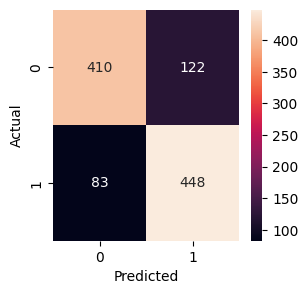

Epoch 2: 100%|███████████████████████████████| 266/266 [00:02<00:00, 107.07it/s]


Train Loss: 0.4610
Validation Loss: 0.4598
ROC AUC: 0.8061
F1: 0.7889
Confusion Matrix:


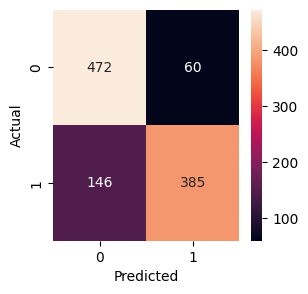

Epoch 3: 100%|███████████████████████████████| 266/266 [00:02<00:00, 102.91it/s]


Train Loss: 0.4330
Validation Loss: 0.3948
ROC AUC: 0.8326
F1: 0.8367
Confusion Matrix:


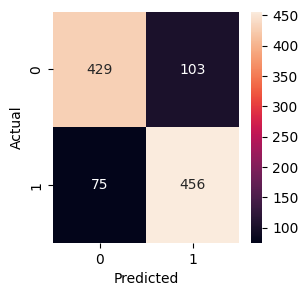

Epoch 4: 100%|███████████████████████████████| 266/266 [00:02<00:00, 101.94it/s]


Train Loss: 0.4083
Validation Loss: 0.3846
ROC AUC: 0.8457
F1: 0.8495
Confusion Matrix:


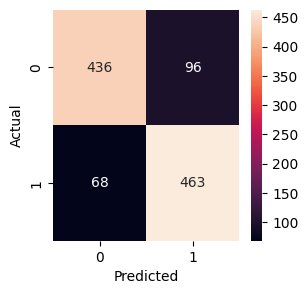

Epoch 5: 100%|███████████████████████████████| 266/266 [00:02<00:00, 102.69it/s]


Train Loss: 0.3572
Validation Loss: 0.3766
ROC AUC: 0.8372
F1: 0.8177
Confusion Matrix:


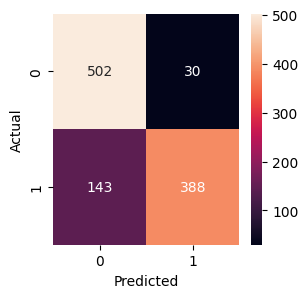

Epoch 6: 100%|███████████████████████████████| 266/266 [00:02<00:00, 100.00it/s]


Train Loss: 0.3016
Validation Loss: 0.3858
ROC AUC: 0.8447
F1: 0.8220
Confusion Matrix:


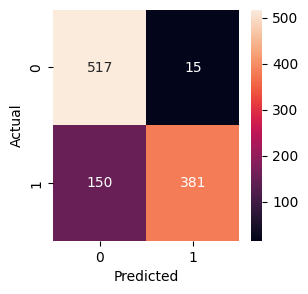

Epoch 7: 100%|███████████████████████████████| 266/266 [00:02<00:00, 102.12it/s]


Train Loss: 0.2857
Validation Loss: 0.3447
ROC AUC: 0.8701
F1: 0.8589
Confusion Matrix:


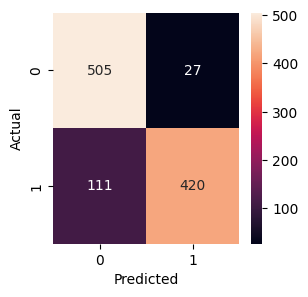

Epoch 8: 100%|███████████████████████████████| 266/266 [00:02<00:00, 103.88it/s]


Train Loss: 0.2543
Validation Loss: 0.3682
ROC AUC: 0.8569
F1: 0.8373
Confusion Matrix:


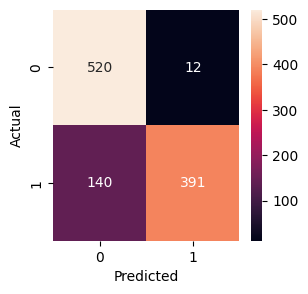

Epoch 9: 100%|████████████████████████████████| 266/266 [00:02<00:00, 97.41it/s]


Train Loss: 0.2308
Validation Loss: 0.3051
ROC AUC: 0.8861
F1: 0.8774
Confusion Matrix:


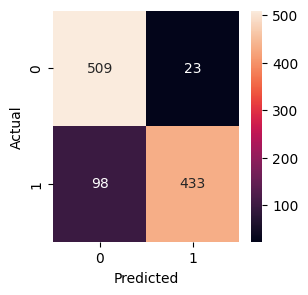

Epoch 10: 100%|██████████████████████████████| 266/266 [00:02<00:00, 105.32it/s]


Train Loss: 0.2160
Validation Loss: 0.3618
ROC AUC: 0.8625
F1: 0.8453
Confusion Matrix:


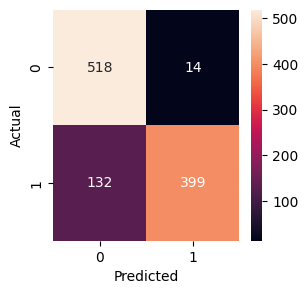

Epoch 11: 100%|██████████████████████████████| 266/266 [00:02<00:00, 102.08it/s]


Train Loss: 0.1979
Validation Loss: 0.2703
ROC AUC: 0.9012
F1: 0.8955
Confusion Matrix:


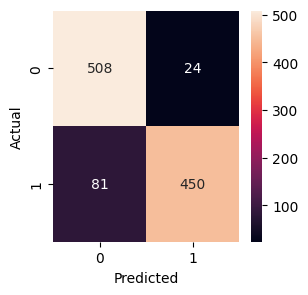

Epoch 12: 100%|███████████████████████████████| 266/266 [00:02<00:00, 99.99it/s]


Train Loss: 0.1804
Validation Loss: 0.2128
ROC AUC: 0.9116
F1: 0.9096
Confusion Matrix:


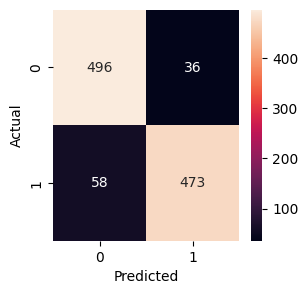

Epoch 13: 100%|██████████████████████████████| 266/266 [00:02<00:00, 106.53it/s]


Train Loss: 0.1688
Validation Loss: 0.2724
ROC AUC: 0.9144
F1: 0.9119
Confusion Matrix:


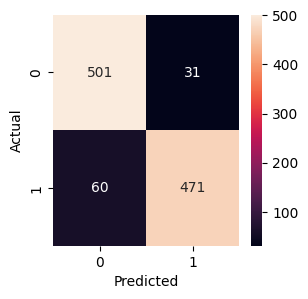

Epoch 14: 100%|██████████████████████████████| 266/266 [00:02<00:00, 100.20it/s]


Train Loss: 0.1547
Validation Loss: 0.2393
ROC AUC: 0.9219
F1: 0.9218
Confusion Matrix:


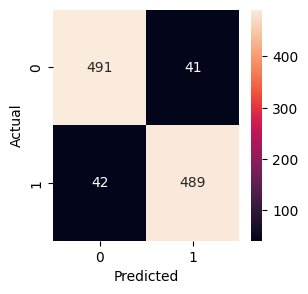

Epoch 15: 100%|███████████████████████████████| 266/266 [00:02<00:00, 99.57it/s]


Train Loss: 0.1466
Validation Loss: 0.2813
ROC AUC: 0.8993
F1: 0.8933
Confusion Matrix:


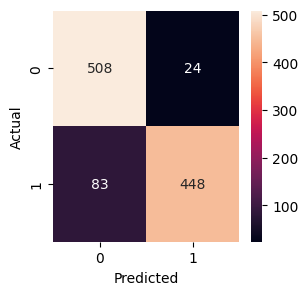


Best Epoch: 12
Best Validation Loss: 0.2128
Best ROC AUC: 0.9116
Best F1: 0.9096



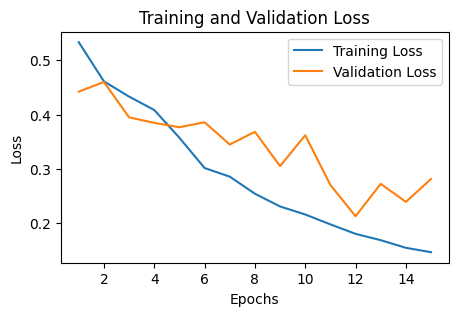

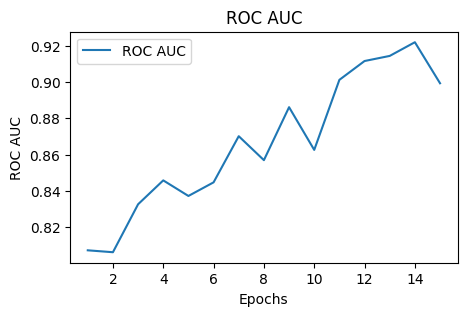

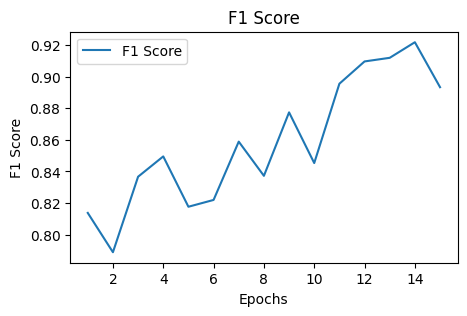

In [22]:
train_model(train_dataloader, valid_dataloader, model, criterion, optimizer)


### 2.1.3 LSTM Hyperparameter Search

In [23]:
def search_hyper_LSTM(key, values, hyper_dict=LSTM_hyper):

    for value in values:
        hyper_dict_copy = copy.deepcopy(hyper_dict)
        print(f"For {key} = {value}:")
        hyper_dict_copy[key] = value
        train_dataloader, valid_dataloader, model, criterion, optimizer = LSTM_init(**hyper_dict_copy)
        train_model(train_dataloader, valid_dataloader, model, criterion,
                    optimizer, verbose=False, checkpoint=False, plot=False)


In [24]:
search_hyper_LSTM('batch_size', [8, 32])


For batch_size = 8:
Best Epoch: 8
Best Validation Loss: 0.2088
Best ROC AUC: 0.9163
Best F1: 0.9153

For batch_size = 32:
Best Epoch: 15
Best Validation Loss: 0.2199
Best ROC AUC: 0.9172
Best F1: 0.9151



In [25]:
search_hyper_LSTM('learning_rate', [2e-3, 2e-5])


For learning_rate = 0.002:
Best Epoch: 3
Best Validation Loss: 0.2574
Best ROC AUC: 0.9078
Best F1: 0.9091

For learning_rate = 2e-05:
Best Epoch: 15
Best Validation Loss: 0.4201
Best ROC AUC: 0.8166
Best F1: 0.8179



In [26]:
search_hyper_LSTM('hidden_dim', [64, 256])


For hidden_dim = 64:
Best Epoch: 15
Best Validation Loss: 0.2348
Best ROC AUC: 0.9059
Best F1: 0.9079

For hidden_dim = 256:
Best Epoch: 12
Best Validation Loss: 0.1993
Best ROC AUC: 0.9276
Best F1: 0.9269



In [27]:
search_hyper_LSTM('dropout', [0.7])


For dropout = 0.7:
Best Epoch: 12
Best Validation Loss: 0.2298
Best ROC AUC: 0.9097
Best F1: 0.9086



In [28]:
search_hyper_LSTM('n_layers', [1])


For n_layers = 1:
Best Epoch: 13
Best Validation Loss: 0.2731
Best ROC AUC: 0.8852
Best F1: 0.8775



Epoch 1: 100%|████████████████████████████████| 532/532 [00:06<00:00, 78.00it/s]


Train Loss: 0.5450
Validation Loss: 0.5637
ROC AUC: 0.7392
F1: 0.6683
Confusion Matrix:


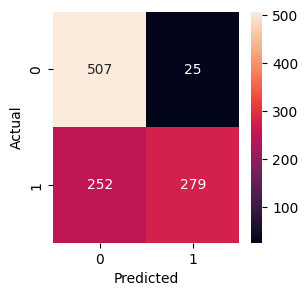

Epoch 2: 100%|████████████████████████████████| 532/532 [00:06<00:00, 88.13it/s]


Train Loss: 0.4525
Validation Loss: 0.4129
ROC AUC: 0.8439
F1: 0.8474
Confusion Matrix:


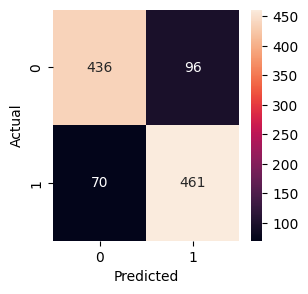

Epoch 3: 100%|████████████████████████████████| 532/532 [00:05<00:00, 90.89it/s]


Train Loss: 0.3886
Validation Loss: 0.2949
ROC AUC: 0.8796
F1: 0.8799
Confusion Matrix:


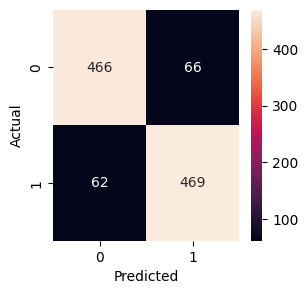

Epoch 4: 100%|████████████████████████████████| 532/532 [00:06<00:00, 87.88it/s]


Train Loss: 0.3139
Validation Loss: 0.2616
ROC AUC: 0.8805
F1: 0.8768
Confusion Matrix:


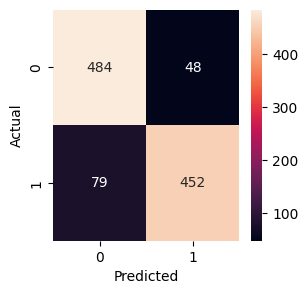

Epoch 5: 100%|████████████████████████████████| 532/532 [00:06<00:00, 87.25it/s]


Train Loss: 0.2674
Validation Loss: 0.3442
ROC AUC: 0.8673
F1: 0.8524
Confusion Matrix:


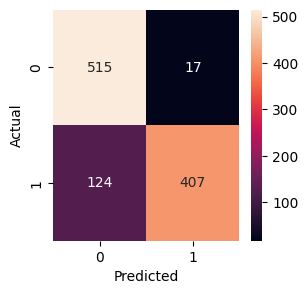

Epoch 6: 100%|████████████████████████████████| 532/532 [00:05<00:00, 92.90it/s]


Train Loss: 0.2396
Validation Loss: 0.3767
ROC AUC: 0.8729
F1: 0.8580
Confusion Matrix:


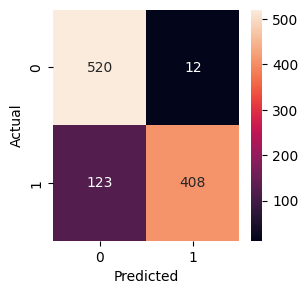

Epoch 7: 100%|████████████████████████████████| 532/532 [00:05<00:00, 90.22it/s]


Train Loss: 0.2138
Validation Loss: 0.2495
ROC AUC: 0.9049
F1: 0.9003
Confusion Matrix:


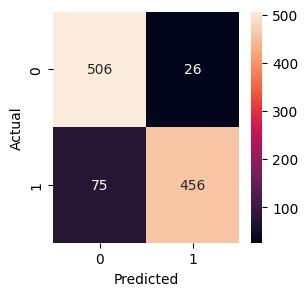

Epoch 8: 100%|████████████████████████████████| 532/532 [00:05<00:00, 89.34it/s]


Train Loss: 0.1872
Validation Loss: 0.2800
ROC AUC: 0.9229
F1: 0.9234
Confusion Matrix:


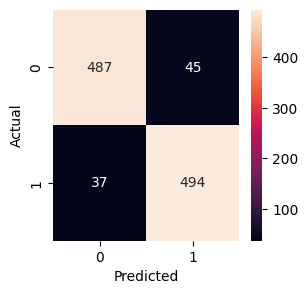

Epoch 9: 100%|████████████████████████████████| 532/532 [00:05<00:00, 90.94it/s]


Train Loss: 0.1815
Validation Loss: 0.1920
ROC AUC: 0.9229
F1: 0.9222
Confusion Matrix:


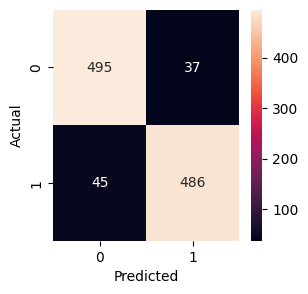

Epoch 10: 100%|███████████████████████████████| 532/532 [00:05<00:00, 93.75it/s]


Train Loss: 0.1592
Validation Loss: 0.2665
ROC AUC: 0.9087
F1: 0.9042
Confusion Matrix:


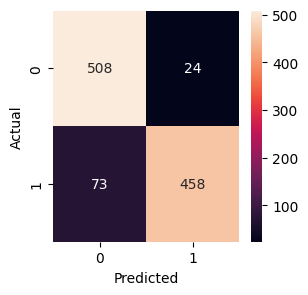

Epoch 11: 100%|███████████████████████████████| 532/532 [00:06<00:00, 84.94it/s]


Train Loss: 0.1424
Validation Loss: 0.3214
ROC AUC: 0.9125
F1: 0.9087
Confusion Matrix:


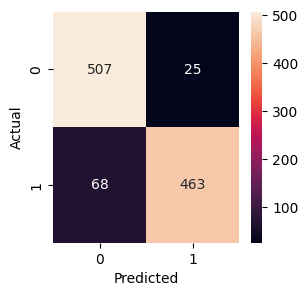

Epoch 12: 100%|███████████████████████████████| 532/532 [00:06<00:00, 87.10it/s]


Train Loss: 0.1307
Validation Loss: 0.3575
ROC AUC: 0.9144
F1: 0.9119
Confusion Matrix:


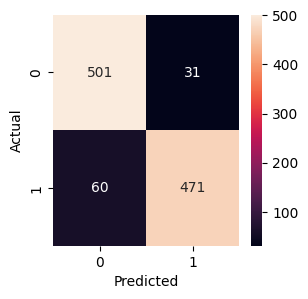

Epoch 13: 100%|███████████████████████████████| 532/532 [00:05<00:00, 90.14it/s]


Train Loss: 0.1217
Validation Loss: 0.2836
ROC AUC: 0.9267
F1: 0.9290
Confusion Matrix:


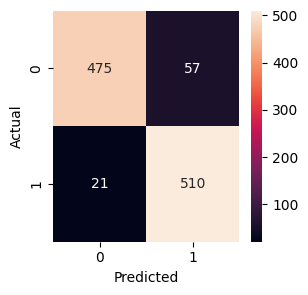

Epoch 14: 100%|███████████████████████████████| 532/532 [00:05<00:00, 89.53it/s]


Train Loss: 0.1313
Validation Loss: 0.2232
ROC AUC: 0.9238
F1: 0.9245
Confusion Matrix:


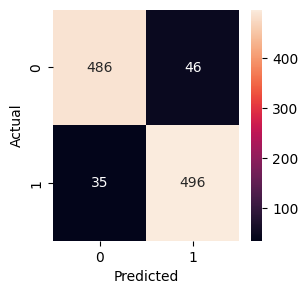

Epoch 15: 100%|███████████████████████████████| 532/532 [00:06<00:00, 87.52it/s]


Train Loss: 0.1032
Validation Loss: 0.3798
ROC AUC: 0.9059
F1: 0.9020
Confusion Matrix:


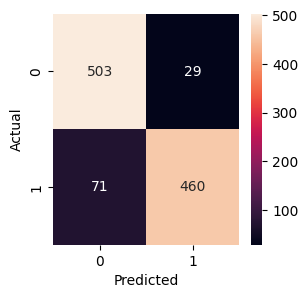


Best Epoch: 9
Best Validation Loss: 0.1920
Best ROC AUC: 0.9229
Best F1: 0.9222



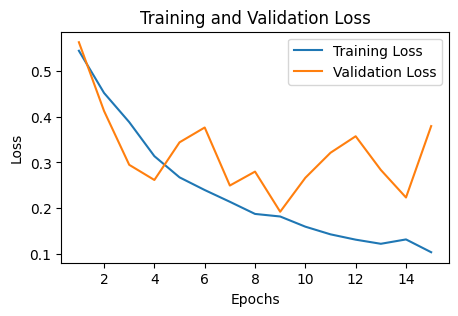

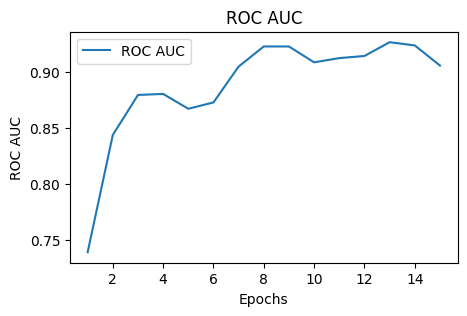

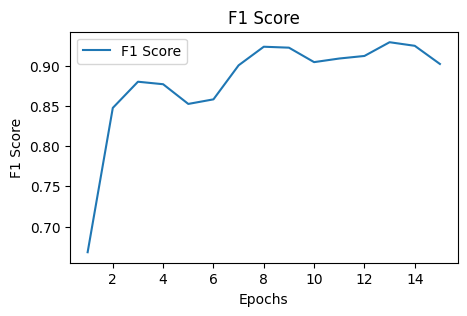

In [45]:
# Hyperparameters dictionary
LSTM_best_hyper = {
    'batch_size': 8,
    'hidden_dim': 256,
    'output_dim': 1,
    'n_layers': 2,
    'dropout': 0.5,
    'pad_idx': vocab['<pad>'],
    'learning_rate': 2e-4,
    'betas': (0.9, 0.999),
    'eps': 1e-8,
    'weight_decay': 0.01
}

train_dataloader, valid_dataloader, model, criterion, optimizer = LSTM_init(**LSTM_best_hyper)
train_model(train_dataloader, valid_dataloader, model, criterion,
            optimizer, verbose=True, checkpoint=True, plot=True)


## 2.2 BERT

In [29]:
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          get_linear_schedule_with_warmup, logging)


logging.set_verbosity_error()


### 2.2.1 BERT Data Preprocessing

In [30]:
df_bert = df_clean.copy(deep=True)


In [31]:
# format the sentence for BERT fine-tuning
# treat the task as a paired sequence classification task, with
# seq A = word(s) of interest and seq B = full sentence.
# data formatted as: seq A [SEP] seq B
df_bert['sentence'] = df_bert['text'] + " [SEP] " + df_bert['words_before'] + ' ' + df_bert['text'] + ' ' + df_bert['words_after']
df_bert = df_bert[['sentence', 'class']]
df_bert.head()


sentence  class
0  distended bowel [SEP] obtained showing an abno...      1
1  liver [SEP] place. The right gutter up over th...      0
2  scleral hemorrhage [SEP] HEENT: Periorbital an...      1
3  redness [SEP] fevers greater than 101.4, chill...      1
4  fatigue [SEP] third day of admission she devel...      1

In [32]:
# split the dataset in a ratio of 8:2 for training and validating
# stratified by class label to ensure balance of labels in both sets
train_data, val_data = train_test_split(df_bert, test_size=0.2, random_state=42, stratify=df_bert['class'])


In [33]:
# load the microsoft PubMedBERT base model and tokenizer
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [34]:
class BERT_Dataset(Dataset):
    """
    Customized dataset for BERT
    """
    def __init__(self, sentence, label, tokenizer):
        self.sentence = sentence
        self.label = label

    def __getitem__(self, idx):
        # use BERT tokenizer to process the sentense
        inputs = tokenizer(self.sentence[idx], padding="max_length", truncation=True,
                           max_length=64, return_tensors="pt")

        # adjust shapes for model inputs
        ids = inputs.input_ids.squeeze(0)
        attn_mask = inputs.attention_mask.squeeze(0)
        return ids, attn_mask, torch.tensor(self.label[idx]).unsqueeze(-1)

    def __len__(self):
        return len(self.sentence)


### 2.2.2 BERT Training

In [35]:
# Hyperparameters dictionary
BERT_hyper = {
    'batch_size': 8,
    'learning_rate': 1e-5,
    'betas': (0.9, 0.999),
    'eps': 1e-8,
    'weight_decay': 0.01
}


In [36]:
def BERT_init(train_data=train_data, val_data=val_data, tokenizer=tokenizer,
              device=device, num_epochs=5, **kwargs):

    # Initialize dataloaders
    train_dataset = BERT_Dataset(train_data['sentence'].values,
                                 train_data['class'].values,
                                 tokenizer)

    train_dataloader = DataLoader(train_dataset, batch_size=kwargs['batch_size'],
                                  shuffle=True)

    valid_dataset = BERT_Dataset(val_data['sentence'].values,
                                 val_data['class'].values,
                                 tokenizer)

    valid_dataloader = DataLoader(valid_dataset, batch_size=1)

    # Initialize model, loss function, optimizer, and scheduler
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1).to(device)

    criterion = nn.BCEWithLogitsLoss()

    optimizer = AdamW(model.parameters(), lr=kwargs['learning_rate'],
                      betas=kwargs['betas'], eps=kwargs['eps'],
                      weight_decay=kwargs['weight_decay'])

    # configure scheduler with warmup to help with finding global minimum
    total_steps = len(train_dataloader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=int(0.1*total_steps),
                                                num_training_steps=total_steps)

    return train_dataloader, valid_dataloader, model, criterion, optimizer, scheduler


In [37]:
train_dataloader, valid_dataloader, model, criterion, optimizer, scheduler = BERT_init(**BERT_hyper)


In [38]:
# standard pytorch training loop
def train_model(train_dataloader, valid_dataloader, model, criterion, optimizer,
                scheduler, num_epochs=5, verbose=True, checkpoint=True, plot=True):
    best_val_loss = 10.0
    train_losses = []
    valid_losses = []
    f1s = []
    roc_aucs = []


    for epoch in range(num_epochs):

        # train
        model.train()
        epoch_loss = 0.0
        epoch_items = 0.0

        for ids, attn_mask, labels in tqdm(
            train_dataloader,
            desc=f"Epoch {epoch+1}",
            total=len(train_dataloader),
            leave=True,
            ncols=80,
            disable=not verbose):

            ids = ids.to(device)
            attn_mask = attn_mask.to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=ids, attention_mask=attn_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item() * ids.size(0)
            epoch_items += ids.size(0)

        train_loss = epoch_loss/epoch_items
        train_losses.append(train_loss)
        if verbose:
            print(f'Train Loss: {train_loss:.4f}')

        # evaluation
        model.eval()
        valid_loss = 0.0
        valid_items = 0.0
        pred_list = []
        true_list = []

        with torch.no_grad():
            for ids, attn_mask, labels  in valid_dataloader:

                ids = ids.to(device)
                attn_mask = attn_mask.to(device)
                labels = labels.float().to(device)

                outputs = model(ids, token_type_ids=None, attention_mask=attn_mask)
                loss = criterion(outputs.logits, labels)

                valid_loss += loss.item() * ids.size(0)
                valid_items += ids.size(0)

                pred = (outputs.logits.detach().cpu().numpy() > 0).astype(int)
                true = labels.to('cpu').numpy()

                pred_list.extend(pred)
                true_list.extend(true)

        valid_loss = valid_loss/valid_items
        valid_losses.append(valid_loss)

        roc_auc = roc_auc_score(true_list, pred_list)
        roc_aucs.append(roc_auc)

        f1 = f1_score(true_list, pred_list)
        f1s.append(f1)

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            best_epoch = epoch + 1
            best_roc_auc = roc_auc
            best_f1 = f1

            if checkpoint:
                torch.save(model.state_dict(), 'Best_BERT.pt')


        if verbose:
            print(f'Validation Loss: {valid_loss:.4f}')
            print(f'ROC AUC: {roc_auc:.4f}')
            print(f'F1: {f1:.4f}')
            print('Confusion Matrix:')
            conf_mat = confusion_matrix(true_list, pred_list)
            plt.figure(figsize=(3,3))
            sns.heatmap(conf_mat, annot=True, fmt='d')
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            plt.show()
            print()

    print(f'Best Epoch: {best_epoch}')
    print(f'Best Validation Loss: {best_val_loss:.4f}')
    print(f'Best ROC AUC: {best_roc_auc:.4f}')
    print(f'Best F1: {best_f1:.4f}')
    print()
    if plot:
        plot_curves(train_losses, valid_losses, roc_aucs, f1s)
        print()


Epoch 1: 100%|████████████████████████████████| 532/532 [00:28<00:00, 18.73it/s]


Train Loss: 0.3169
Validation Loss: 0.1061
ROC AUC: 0.9652
F1: 0.9662
Confusion Matrix:


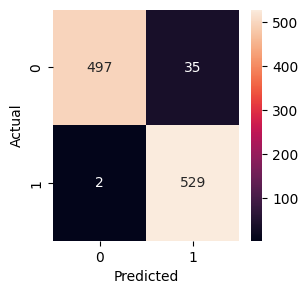

Epoch 2: 100%|████████████████████████████████| 532/532 [00:28<00:00, 18.77it/s]


Train Loss: 0.0730
Validation Loss: 0.0750
ROC AUC: 0.9803
F1: 0.9805
Confusion Matrix:


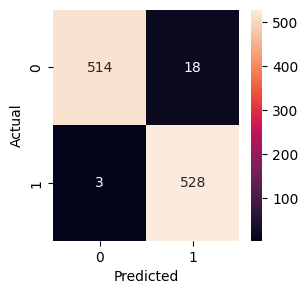

Epoch 3: 100%|████████████████████████████████| 532/532 [00:28<00:00, 18.76it/s]


Train Loss: 0.0445
Validation Loss: 0.0720
ROC AUC: 0.9793
F1: 0.9796
Confusion Matrix:


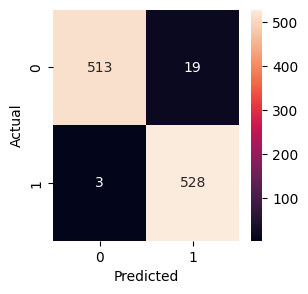

Epoch 4: 100%|████████████████████████████████| 532/532 [00:28<00:00, 18.51it/s]


Train Loss: 0.0310
Validation Loss: 0.0772
ROC AUC: 0.9812
F1: 0.9814
Confusion Matrix:


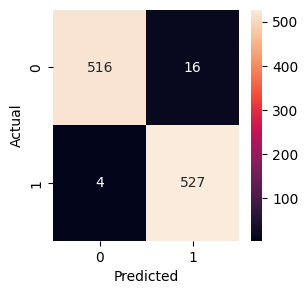

Epoch 5: 100%|████████████████████████████████| 532/532 [00:28<00:00, 18.70it/s]


Train Loss: 0.0214
Validation Loss: 0.0776
ROC AUC: 0.9812
F1: 0.9814
Confusion Matrix:


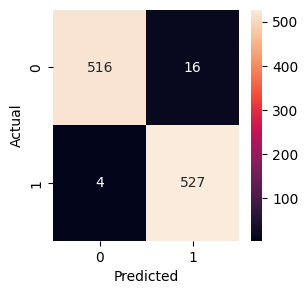


Best Epoch: 3
Best Validation Loss: 0.0720
Best ROC AUC: 0.9793
Best F1: 0.9796



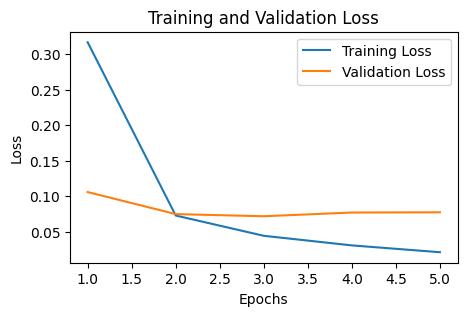

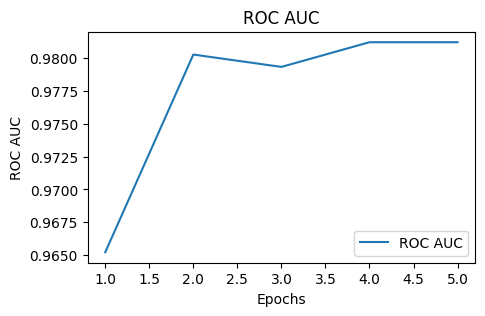

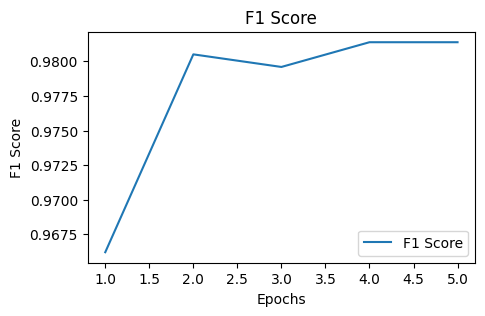

In [39]:
train_model(train_dataloader, valid_dataloader, model, criterion, optimizer,
            scheduler)


### 2.2.3 BERT Hyperparameter Search

In [40]:
def search_hyper_BERT(key, values, hyper_dict=BERT_hyper):

    for value in values:
        hyper_dict_copy = copy.deepcopy(hyper_dict)
        print(f"For {key} = {value}:")
        hyper_dict_copy[key] = value
        train_dataloader, valid_dataloader, model, criterion, optimizer, scheduler = BERT_init(**hyper_dict_copy)
        train_model(train_dataloader, valid_dataloader, model, criterion,
                    optimizer, scheduler, verbose=False, checkpoint=False,
                    plot=False)


In [41]:
search_hyper_BERT('batch_size', [16, 32])


For batch_size = 16:
Best Epoch: 2
Best Validation Loss: 0.0756
Best ROC AUC: 0.9793
Best F1: 0.9796

For batch_size = 32:
Best Epoch: 2
Best Validation Loss: 0.0797
Best ROC AUC: 0.9755
Best F1: 0.9755



In [42]:
search_hyper_BERT('learning_rate', [1e-4, 1e-6])


For learning_rate = 0.0001:
Best Epoch: 4
Best Validation Loss: 0.0870
Best ROC AUC: 0.9774
Best F1: 0.9777

For learning_rate = 1e-06:
Best Epoch: 5
Best Validation Loss: 0.1151
Best ROC AUC: 0.9643
Best F1: 0.9646

